# Deep Learning for Computer Vision:  Assignment 4

## Computer Science: COMS W 4995 006

### Due: March 20, 2018

### Problem

In this notebook we provide three networks for classifying handwritten digits from the MNIST dataset. The networks are implemented and tested using the Tensorflow framework. The third and final network is a convolutional neural network (CNN aka ConvNet) which achieves 99.25% accuracy on this dataset. 

Your task is to re-implement all three networks using the Keras wrapper around Tensorflow OR
re-implement using Pytorch. You will likely find several Keras or Pytorch implementations on the internet. It is ok to study these. However, you must not cut and paste this code into your assignment--you must write this yourself. Furthermore, you need to comment every line of code and succintly explain what it is doing! 

Here is what is required:

a) A FULLY commented re-implementation of the ConvNet below using the Keras wrapper on Tensorflow OR Pytorch.

b) your network trained on the same MNIST data as used here.

c) an evaluation of the accuracy on the MNIST test set.

d) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.

e) have your training record a log of the data using the Keras API and then use Tensorboard (a command line tool) to display plots of the validation loss and validation accuracy. you can zip up a screenshot of this with your notebook before submission.

f) have your training continually save the best model so far (as determined by the validation loss) using the Keras API or Pytorch.

g) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

Below we include the Tensorflow examples shown in class.

### A Simple Convolutional Neural Network in Tensorflow

This notebook covers a python and tensorflow-based solution to the handwritten digits recognition problem. It is based on tensorflow tutorials and Yann LeCun's early work on CNN's. This toturial compares a simple softmax regressor, a multi-layer perceptron (MLP), and a simple convolutional neural network (CNN).

Load in the MNIST digit dataset directly from tensorflow examples.

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). 

Let's import tensorflow and begin an interactive session.

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

## Softmax Regression Model on the MNIST Digits Data

We need to create placeholders for the data. Data will be dumped here when it is batched from the MNIST dataset.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Now let's see what this data looks like.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(4):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Below we create the parameters (weights) for our linear layer.

In [ ]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

We then use tensorflows initializer to initialize these weights.

In [ ]:
sess.run(tf.global_variables_initializer())

We create our linear layer as a function of the input and the weights.

In [ ]:
y_regressor = tf.matmul(x,W) + b

Below we create our loss function. Note that the cross entropy is $ H_{\hat{y}}(y) = -\sum_i \hat{y}_{i} \, \log(y_{i})$ where $\hat{y}$ is the true probability distribution and is expressed as a one-hot vector, $y$ is the estimated probability distribution, and $i$ indexes elements of these two vectors. Also note that this reduces to $ H_{\hat{y}}(y) = -\, \log(y_{i^*})$ where $i^*$ is the correct label. And if we sum this over all of our samples indexed by $j$, then $H_{\hat{y}}(y) = -\sum_j  \log(y^{(j)}_{i^*})$. This is precisely the same loss function as we used before, but we called the MLE loss. They are one and the same.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_regressor))

Now we tell tf to use gradient descent with a step size of 0.5 and to minimize the cross entropy.

In [ ]:
a = tf.constant([[[1,2,3],
                [4,5,6],
                [7,8,9]],
                 [[1,2,3],
                [4,5,6],
                [7,8,9]],
                 [[1,2,3],
                [4,5,6],
                [7,8,9]]])

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [ ]:
sess.run(a_slice)

We train by grabbing mini-batches with 100 samples each and pushing these through the network to update our weights (W and b).

In [ ]:
for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

We define how to compute correct predicitions.

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_regressor,1), tf.argmax(y_,1))

And from these correct predictions how to compute the accuracy.

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Let's print out some test images and the corresponsing predictions made by the network. But first, let's add an output to the computation graph that computes the softmax probabilities.

In [ ]:
y_probs_regressor = tf.nn.softmax(logits=y_regressor, name=None)

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print ("Label = ", label)
    print ("Class probabilities = ", y_probs_regressor.eval(feed_dict={
        x: batch[0], y_: batch[1]}))

## Softmax Multi-Layer Perceptron on the MNIST Digits Data

Here we define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU. 

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Next we create placeholders for the training data.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

We create the first and only fully connected hidden layer.

In [ ]:
W_h = weight_variable([784, 512])
b_h = bias_variable([512])
h = tf.nn.relu(tf.matmul(x, W_h) + b_h)

We create the output layer.

In [ ]:
W_out = weight_variable([512, 10])
b_out = bias_variable([10])
y_MLP = tf.matmul(h, W_out) + b_out

We again use cross entropy loss on a softmax distribution on the outputs.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_MLP))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training. Note this softmax MLP network does quite a bit bettter than our softmax regressor. The non-linear layer really helps makes sense of the data! But we can do better still...

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_MLP,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1]})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

## A Simple Convolutional Neural Network: LeNet

Here we make our first CNN. It's quite simple network, but it's surprisingly good at this handwritten digit recognition task. This a variant on Yann LeCun's CNN network that really helped to move deep learning forward.

We define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLu. 

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Next we define how the convolution is to be computed and the extent and type of pooling. The convolution will use a 5x5 kernel and will pad the image with zeros around the edges and use a stride of 1 pixel so that the resulting image (after convolution) has the same size as the original input image. The network will learn the weights for a stack of 32 separate kernels along with 32 bias variables. Finally, after the ReLu is performed the result will be under go 2x2 max pooling, thus halfing both dimensions of the image. The choices for the stride, padding, and pooling are not parameters that the network needs to estimate. Rather these are termed "hyperparamters" that are usually set by the network designer.

In [ ]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

This creates the weight and bias variables for the first convolutional layer as described above. Note the output has depth 32, so there will be 32 feature images after this layer.

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Unlike for our softmax regressor above, here we need keep the images as images and not collapse these into vectors; this allows us to perform the 2D convolution.

In [ ]:
x_image = tf.reshape(x, [-1,28,28,1])

Finally, we define are first layer of our CNN!

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

And wasting no time, we define are second layer. The second layer will have to process 32 feature images coming out of the first layer. Note that the images input to this layer have $\frac{1}{4}$ the number of pixels as the original input images due to the 2x2 pooling in the previous layer. Note that convolution layer NOT fully connected as our previous hidden layers have been. A unit in the output layer has a limited "receptive field." Its connections to the input layer are spatially limited by the kernel (or filter) size. Also, because of weight sharing in convolutional layers, the number of parameters for a convolutional is the size of the kernel x the depth of the input layer x depth of the output layer + depth of the output layer. So for the second layer of our ConvNet, we have 5 x 5 x 32 x 64 + 64 = 51,264 parameters. 

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

After the pooling stage of our second convolutional layer, we have 64 7x7 "feature" images. In one penultimate fully connected hidden layer, we are going to map these feature imges to a 1024 dimensional feature space. Note we need to flatten these feature images to do this.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout is added here, although it is not really needed for such small network.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

We have a final linear output layer mapping features to scores topped off with a softmax cross entropy loss function, as explained earlier.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training.

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

We add an output to compuational graph that computes the label probabilities.

In [ ]:
y_probs = tf.nn.softmax(logits=y_conv, name=None)

In [ ]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Next we step through some test examples and see how well the network is doing.

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print ("Label = ", label)
    print ("Class probabilities = ", y_probs.eval(feed_dict={
        x: batch[0], y_: batch[1], keep_prob: 1.0}))

# Keras Implementation start here

In [1]:
# import library 
import numpy as np
import matplotlib.pyplot as plt
# import keras library and some utility
import keras
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.
/Users/yuwang/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# define the shape of the image
rows, cols = 28, 28

In [3]:
# function to feed the data for the network
def get_data(input_shape):
    """
    input shape: the shape required by the first layer of keras
    for Q1 and Q2 it's (784,) for Q3 it's (28, 28, 1)
    """
    # load the data from mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # turn the data into float32 format
    X_train = X_train.astype('float32') 
    X_test = X_test.astype('float32') 
    # normalize the data (data read from tensorflow is normalized but not keras)
    X_train /= 255 
    X_test /= 255
    # reshape the data into the format (batchsize, input_format)
    X_train = X_train.reshape((X_train.shape[0],) + input_shape)
    X_test = X_test.reshape((X_test.shape[0],) + input_shape)
    # reshape the label into one-hot encoding vector
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    return X_train, X_test, y_train, y_test

In [4]:
# function to train the network
def train(model, X_train, y_train, model_name, batch_size, epochs):
    """
    model: the defined model
    X_train: training sample feature vector
    y_train: training sample label
    model_name: str passed as the prefix of model weights and tensorboard file
    batch_size: batch_size
    epochs: epochs
    """
    # define the file to save the best weights
    filepath= model_name + ".weights.best.hdf5"
    # define the file to store tensorboard file
    log_dir = './logs/' + model_name
    # define the callback for model checkpoint to store the best model weights after every epoch
    # best model determined by the validation loss
    ckpt_callback = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    # define the callback for tensorboard visualization
    tfboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=True, write_images=True)
    # define the callback list to put in the argument of model.fit
    callbacks_list = [ckpt_callback, tfboard_callback]
    # fit the model with training data 
    # I use the validation_split provided by keras API to do test_validation split here, it's much simpler
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, verbose = 1, validation_split=0.2)
    return filepath, log_dir

In [5]:
# evalute function to get the accuracy of the model
def evaluate(model, X_test, y_test):
    """
    model: the predefined and trained model architecture
    X_test: testing sample feature vector
    y_test: testing sample label
    """
    # get the loss and accuracy of the model
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    # print the loss and accuracy
    print ("Test Loss: %f" % loss)
    print ("Test Accuracy: %f" % acc)

In [6]:
# function to plot 10 randomly selected digits from the test set along with the correct label and the assigned label.
def plot_digits(model, X_test, y_test, input_shape):
    """
    model: the predefined and trained model architecture
    X_test: testing sample feature vector
    y_test: testing sample label
    input_shape: the pre-processed input shape 
    """
    # the ten randomly selected sample
    plot_list_X = np.random.randint(0, X_test.shape[0], size = 10)
    for plot_X in plot_list_X:
        # get the sample data
        batch = X_test[plot_X]
        # reshape the data into input shape for the model
        batch = batch.reshape((1, ) + input_shape)
        # get the softmax probability
        class_probability = model.predict(batch, batch_size=1, verbose=1)
        # get the image for display
        image = np.asarray(batch).reshape((rows, cols))
        # get the predicted label
        label = np.argmax(y_test[plot_X])

        # show the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        # print the result
        print ("Label = ", label)
        print ("predicted Label = ", np.argmax(class_probability))
        print ("Class probabilities = ", class_probability)

In [7]:
# function to get the result of stored best model
def get_best_model(filepath, X_test, y_test):
    # load the model weights from file
    best_model = keras.models.load_model(filepath)
    # get the loss and accuracy
    best_loss, best_acc = best_model.evaluate(X_test, y_test, verbose=1)
    # print the result
    print ("Best Test Loss: %f" % best_loss)
    print ("Best Test Accuracy: %f" % best_acc)

## Model1 Softmax Regression Model on the MNIST Digits Data

In [35]:
# define the softmax model
def get_Model(input_shape):
    """
    input_shape: the required shape for the keras API
    """
    # use the sequential model, which is a linear stack of layers
    model = Sequential()
    # add a dense layer with ten neurons and use softmax function to get class probabilities
    model.add(Dense(10, input_shape = input_shape, activation='softmax', use_bias=True, \
                    kernel_initializer = keras.initializers.Zeros(), \
                   bias_initializer = keras.initializers.Zeros()))
    # use vallina SGD optimizer
    sgd = keras.optimizers.SGD(lr=0.5)
    # configure the model for training
    # use cross entropy loss and use accuracy metrics
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [36]:
# define input shape
input_shape = (784,)
# get the shaped data
X_train, X_test, y_train, y_test = get_data(input_shape)
# configure the model
model = get_Model(input_shape)
# train the model on train dataset
filepath, log_dir = train(model, X_train, y_train, "softmax", 100, 20)
print (filepath, log_dir)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 39us/step - loss: 0.4143 - acc: 0.8824 - val_loss: 0.3117 - val_acc: 0.9096
Epoch 2/20
48000/48000 [==============================] - 1s 29us/step - loss: 0.3153 - acc: 0.9097 - val_loss: 0.2951 - val_acc: 0.9162
Epoch 3/20
48000/48000 [==============================] - 2s 32us/step - loss: 0.2995 - acc: 0.9152 - val_loss: 0.2823 - val_acc: 0.9198
Epoch 4/20
48000/48000 [==============================] - 2s 38us/step - loss: 0.2906 - acc: 0.9178 - val_loss: 0.2822 - val_acc: 0.9237
Epoch 5/20
48000/48000 [==============================] - 1s 28us/step - loss: 0.2848 - acc: 0.9201 - val_loss: 0.2754 - val_acc: 0.9241
Epoch 6/20
48000/48000 [==============================] - 1s 28us/step - loss: 0.2798 - acc: 0.9212 - val_loss: 0.2789 - val_acc: 0.9227
Epoch 7/20
48000/48000 [==============================] - 1s 26us/step - loss: 0.2772 - acc: 0.9214 - val_loss: 0.2735 - val_acc

In [25]:
# evaluate the accuracy of the model on test dataset
evaluate(model, X_test, y_test)

10000/10000 [==============================] - 1s 61us/step
Test Loss: 0.273234
Test Accuracy: 0.924400


1/1 [==============================] - 0s 69ms/step


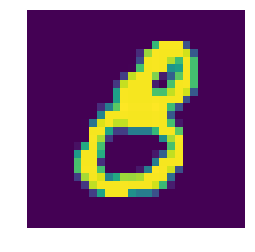

Label =  8
predicted Label =  3
Class probabilities =  [[  2.76367995e-04   9.89590080e-06   1.29556036e-04   9.07509029e-01
    1.66209647e-05   4.21560630e-02   9.90638182e-06   2.31323618e-08
    4.94518653e-02   4.40765521e-04]]
1/1 [==============================] - 0s 1ms/step


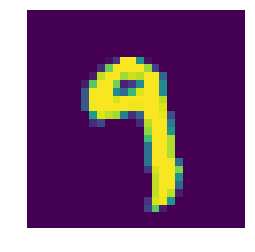

Label =  9
predicted Label =  9
Class probabilities =  [[  1.70327275e-09   3.17045851e-05   6.72737173e-08   2.61497148e-03
    4.66641691e-03   4.25087940e-03   1.61785906e-07   1.51970992e-02
    1.19366357e-03   9.72045064e-01]]
1/1 [==============================] - 0s 798us/step


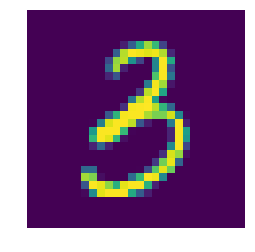

Label =  3
predicted Label =  3
Class probabilities =  [[  4.13179491e-03   6.26983412e-04   4.11716895e-03   9.39860165e-01
    9.32821713e-05   3.34457904e-02   3.31012357e-04   2.52840010e-07
    1.71198696e-02   2.73840735e-04]]
1/1 [==============================] - 0s 755us/step


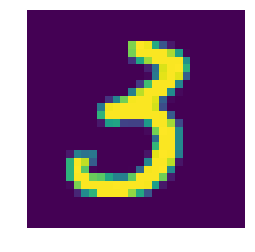

Label =  3
predicted Label =  3
Class probabilities =  [[  1.45787490e-05   1.08805648e-06   5.65045557e-05   9.88854647e-01
    2.61258697e-06   1.05692400e-02   4.59639260e-08   3.88621624e-09
    4.99872724e-04   1.40623388e-06]]
1/1 [==============================] - 0s 697us/step


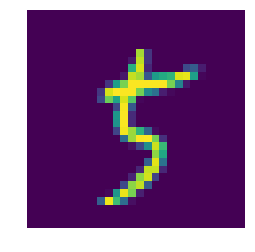

Label =  5
predicted Label =  5
Class probabilities =  [[  2.46744463e-03   1.16999811e-02   3.90658062e-03   2.20997930e-02
    6.98171509e-03   8.61621737e-01   3.15967845e-05   6.82421320e-04
    8.26993585e-02   7.80934328e-03]]
1/1 [==============================] - 0s 694us/step


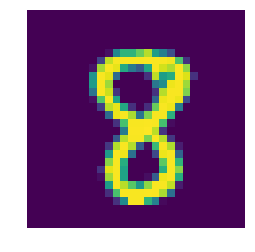

Label =  8
predicted Label =  8
Class probabilities =  [[  2.20017796e-06   6.35356088e-08   4.71228827e-03   2.19509471e-03
    1.18986227e-05   2.11692197e-04   2.06989881e-07   6.64462448e-07
    9.92304504e-01   5.61375578e-04]]
1/1 [==============================] - 0s 2ms/step


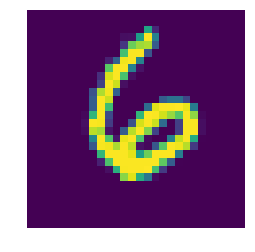

Label =  6
predicted Label =  6
Class probabilities =  [[  4.26709192e-08   1.23425778e-07   6.79359713e-04   2.95783309e-07
    1.65245699e-04   9.36124707e-07   9.99093771e-01   7.67595850e-07
    4.16733310e-05   1.77068068e-05]]
1/1 [==============================] - 0s 973us/step


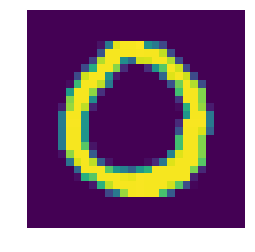

Label =  0
predicted Label =  0
Class probabilities =  [[  9.92174506e-01   3.84863989e-14   4.82189655e-03   7.57051050e-04
    4.07153686e-11   2.22961581e-03   3.50025266e-06   4.56730598e-10
    1.33718522e-05   2.68050859e-10]]
1/1 [==============================] - 0s 524us/step


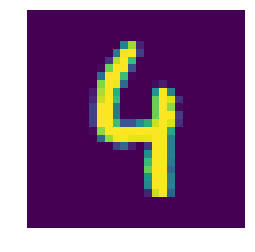

Label =  4
predicted Label =  4
Class probabilities =  [[  3.62008379e-08   6.48404921e-07   1.22569210e-04   4.81330353e-04
    9.88172710e-01   2.00686976e-04   8.01230490e-04   4.03796221e-05
    1.04792020e-03   9.13259014e-03]]
1/1 [==============================] - 0s 1ms/step


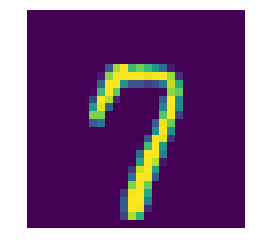

Label =  7
predicted Label =  7
Class probabilities =  [[  1.24898725e-04   1.62897216e-08   1.30813178e-05   8.64558853e-04
    1.23930178e-04   3.33152665e-03   3.88626660e-07   7.52221048e-01
    2.32371516e-04   2.43088216e-01]]


In [26]:
# plot 10 randomly selected digits from test dataset
plot_digits(model, X_test, y_test, input_shape)

In [27]:
# re-run the accuracy evaluation on the test model using the save best weights
get_best_model(filepath, X_test, y_test)

10000/10000 [==============================] - 0s 40us/step
Best Test Loss: 0.270258
Best Test Accuracy: 0.923900


## Model2 Softmax Multi-Layer Perceptron on the MNIST Digits Data

In [37]:
# define the mlp model
def get_Model(input_shape):
    """
    input_shape: the required shape for the keras API
    """
    # kernal_intializer with truncated normal std_dev 0.1 and mean 0.0
    kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)
    # bias_initializer with constant 0.1
    bias_initializer = keras.initializers.Constant(value=0.1)
    # use the sequential model, which is a linear stack of layers
    model = Sequential()
    # add a dense layer with 512 neurons and use relu as activation function after affine layer
    model.add(Dense(512, input_shape = input_shape, activation='relu', \
                    kernel_initializer = kernel_initializer, \
                    bias_initializer = bias_initializer))
    # add a dense(output) layer with 10 neurons and use softmax to get class probabilities
    model.add(Dense(10, activation='softmax',  \
                    kernel_initializer = kernel_initializer, \
                    bias_initializer = bias_initializer))
    # use adam optimizer
    adam = keras.optimizers.Adam(lr=1e-4)
    # fit the model with training data 
    # I use the validation_split provided by keras API to do test_validation split here, it's much simpler
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

In [38]:
# define input shape
input_shape = (784,)
# get the shaped data
X_train, X_test, y_train, y_test = get_data(input_shape)
# configure the model
model = get_Model(input_shape)
# train the model on train dataset
filepath, log_dir = train(model, X_train, y_train, "mlp", 50, 20)
print (filepath, log_dir)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
22850/48000 [=============>................] - ETA: 7s - loss: 0.8115 - acc: 0.7680

KeyboardInterrupt: 

In [15]:
# evaluate the accuracy of the model on test dataset
evaluate(model, X_test, y_test)

10000/10000 [==============================] - 1s 97us/step
Test Loss: 0.071363
Test Accuracy: 0.978600


1/1 [==============================] - 0s 37ms/step


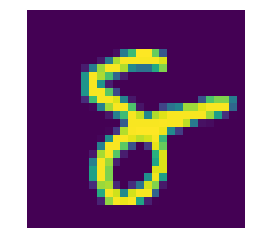

Label =  8
predicted Label =  8
Class probabilities =  [[  5.77793147e-09   1.66748993e-11   1.69146108e-06   6.11855144e-09
    1.01746316e-07   4.83211124e-07   6.86456971e-08   1.15823862e-09
    9.99997258e-01   3.68980579e-07]]
1/1 [==============================] - 0s 2ms/step


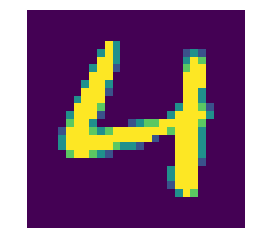

Label =  4
predicted Label =  4
Class probabilities =  [[  2.92765293e-07   1.19318766e-09   1.16083193e-07   3.36805750e-10
    9.99981999e-01   4.39995738e-08   9.50273989e-06   7.07592562e-08
    9.01817486e-07   7.12611381e-06]]
1/1 [==============================] - 0s 2ms/step


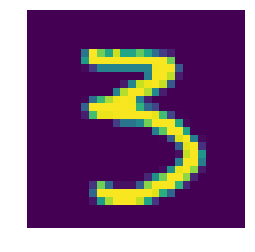

Label =  3
predicted Label =  3
Class probabilities =  [[  2.05246717e-08   1.44127478e-06   5.50772370e-07   9.99566257e-01
    1.57148634e-07   3.73587362e-04   3.93323499e-11   2.95522739e-07
    4.49789331e-05   1.28716583e-05]]
1/1 [==============================] - 0s 2ms/step


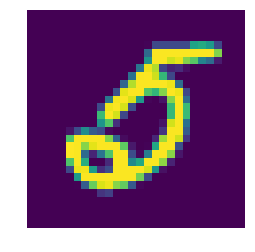

Label =  5
predicted Label =  0
Class probabilities =  [[  9.54649448e-01   7.12603764e-07   3.14655388e-03   4.69249813e-03
    6.69180066e-04   1.39336828e-02   2.28506587e-02   8.42332781e-07
    4.61889249e-05   1.02604226e-05]]
1/1 [==============================] - 0s 1ms/step


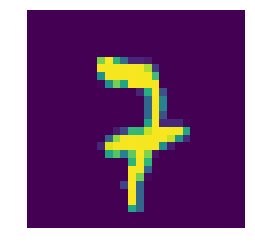

Label =  7
predicted Label =  7
Class probabilities =  [[  4.91858316e-07   4.30515365e-06   9.15177108e-04   1.18107314e-03
    3.26308827e-06   1.01401433e-07   7.63633011e-07   9.97843981e-01
    7.43692817e-06   4.33743589e-05]]
1/1 [==============================] - 0s 993us/step


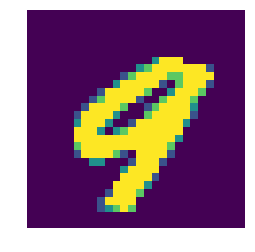

Label =  9
predicted Label =  9
Class probabilities =  [[  1.68720578e-06   4.20459952e-11   2.38611875e-07   1.38741225e-05
    7.29068997e-05   1.88692354e-07   2.35165132e-09   6.93742186e-06
    1.32321104e-04   9.99771893e-01]]
1/1 [==============================] - 0s 2ms/step


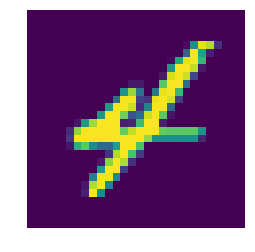

Label =  4
predicted Label =  4
Class probabilities =  [[  2.88184810e-06   1.26839050e-05   1.49038460e-05   7.35788461e-08
    9.99852538e-01   5.82827852e-07   1.05791143e-04   5.88020885e-06
    3.83620863e-06   7.90232832e-07]]
1/1 [==============================] - 0s 2ms/step


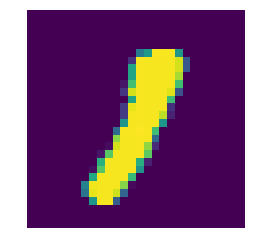

Label =  1
predicted Label =  1
Class probabilities =  [[  1.57714880e-04   9.75054562e-01   2.57300126e-04   6.23580010e-04
    3.43757347e-06   1.48463741e-05   2.01863671e-07   9.44280904e-03
    1.27041861e-02   1.74128788e-03]]
1/1 [==============================] - 0s 4ms/step


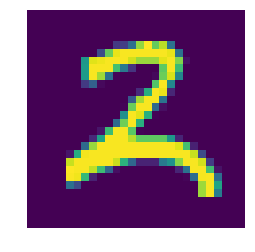

Label =  2
predicted Label =  2
Class probabilities =  [[  5.66266312e-10   2.85997316e-07   9.99745667e-01   2.49856785e-05
    2.83391159e-07   4.20790784e-05   2.18781366e-08   2.52788965e-07
    1.86559875e-04   4.90352736e-09]]
1/1 [==============================] - 0s 1ms/step


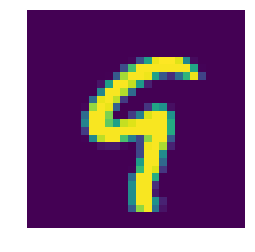

Label =  9
predicted Label =  9
Class probabilities =  [[  2.19677543e-09   5.32710338e-08   7.31317442e-08   1.32005914e-06
    1.07770931e-04   1.12509038e-02   5.74989315e-07   2.89723812e-06
    1.69961004e-05   9.88619447e-01]]


In [16]:
# plot 10 randomly selected digits from test dataset
plot_digits(model, X_test, y_test, input_shape)

In [17]:
# re-run the accuracy evaluation on the test model using the save best weights
get_best_model(filepath, X_test, y_test)

10000/10000 [==============================] - 1s 79us/step
Best Test Loss: 0.071363
Best Test Accuracy: 0.978600


## Model3 A Simple Convolutional Neural Network: LeNet

In [39]:
# define the LeNet model
def get_Model(input_shape):
    """
    input_shape: the required shape for the keras API
    """
    # kernal_intializer with Truncated Normal std_dev 0.1 and mean 0.0
    kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)
    # bias_initializer with constant 0.1
    bias_initializer = keras.initializers.Constant(value=0.1)
    # use the sequential model, which is a linear stack of layers
    model = Sequential()
    # add a conv layer with 32 filters of kernel_size (5,5), use same padding to keep the dimensions
    # use default strides (1,1) and relu function as activaion 
    model.add(Conv2D(32, (5, 5), padding = "same", kernel_initializer = kernel_initializer, \
                     bias_initializer = bias_initializer, \
                     input_shape = input_shape, activation = "relu", use_bias = True))
    # add a pooling layer with pool_size of (2,2) and default strides of (2,2), 
    # use same padding to reduce the dimensions to half
    model.add(MaxPooling2D(pool_size=(2, 2), padding = "same"))
    # add a conv layer with 64 filters of kernel_size (5,5), use padding to keep the dimensions
    # use default strides (1,1) and relu function as activaion 
    model.add(Conv2D(64, (5, 5), padding = "same",  kernel_initializer = kernel_initializer, \
                     bias_initializer = bias_initializer, activation = "relu", use_bias = True))
    # add a pooling layer with pool_size of (2,2) and default strides of (2,2), 
    # use same padding to reduce the dimensions to half
    model.add(MaxPooling2D(pool_size=(2, 2), padding = "same"))
    # flatten the vetctor for input to dense layer
    model.add(Flatten())
    # add a dense layer with 1024 neurons and use relu as activation function after linear layer
    model.add(Dense(1024, activation = "relu", \
                    kernel_initializer = kernel_initializer, bias_initializer = bias_initializer))
    # add dropout with 50% keep rate
    model.add(Dropout(0.5))
    # add a dense layer with 10 neurons and use softmax function to get class probability
    model.add(Dense(10, activation='softmax', kernel_initializer = kernel_initializer, \
                    bias_initializer = bias_initializer))
    # use adam optimizer
    adam = keras.optimizers.Adam(lr=1e-4)
    # fit the model with training data 
    # I use the validation_split provided by keras API to do test_validation split here, it's much simpler
    model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
    return model

In [40]:
# define input shape
input_shape = (rows, cols, 1)
# get the shaped data
X_train, X_test, y_train, y_test = get_data(input_shape)
# configure the model
model = get_Model(input_shape)
# train the model on train dataset
filepath, log_dir = train(model, X_train, y_train, "LeNet", 50, 12)
print (filepath, log_dir)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 246s 5ms/step - loss: 0.6810 - acc: 0.8350 - val_loss: 0.1183 - val_acc: 0.9645
Epoch 2/12
 8300/48000 [====>.........................] - ETA: 3:08 - loss: 0.1836 - acc: 0.9422

KeyboardInterrupt: 

In [20]:
# evaluate the accuracy of the model on test dataset
evaluate(model, X_test, y_test)

10000/10000 [==============================] - 16s 2ms/step
Test Loss: 0.022507
Test Accuracy: 0.991700


1/1 [==============================] - 0s 116ms/step


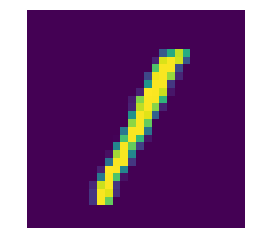

Label =  1
predicted Label =  1
Class probabilities =  [[  5.31246833e-08   9.99907970e-01   2.04114571e-07   6.40227177e-11
    8.24502858e-05   2.36676789e-09   5.06837353e-07   8.33751346e-06
    3.74613364e-07   9.28723409e-08]]
1/1 [==============================] - 0s 5ms/step


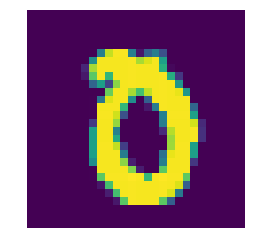

Label =  0
predicted Label =  0
Class probabilities =  [[  9.99986768e-01   3.40331474e-09   2.10760436e-06   1.26232507e-07
    5.44766676e-10   7.19549575e-08   2.08531424e-06   9.36479481e-08
    8.77205093e-06   1.14270895e-08]]
1/1 [==============================] - 0s 7ms/step


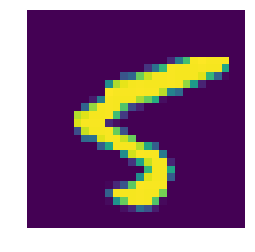

Label =  5
predicted Label =  5
Class probabilities =  [[  2.14967887e-11   4.60546748e-13   7.51166842e-14   8.17207546e-09
    1.92182692e-09   9.99983311e-01   1.35234679e-09   2.47562023e-11
    1.66193749e-05   1.95811083e-08]]
1/1 [==============================] - 0s 9ms/step


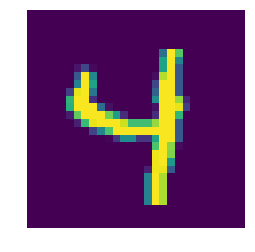

Label =  4
predicted Label =  4
Class probabilities =  [[  5.89013921e-15   5.71579156e-12   2.23981380e-12   1.41752549e-13
    9.99998569e-01   7.48903023e-12   1.88067064e-15   8.01382571e-10
    2.31460895e-09   1.47646904e-06]]
1/1 [==============================] - 0s 4ms/step


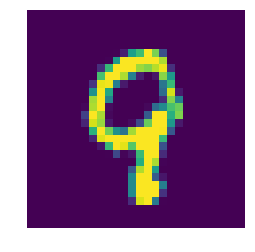

Label =  9
predicted Label =  9
Class probabilities =  [[  4.87702367e-09   6.48234888e-09   2.54918177e-07   1.76811255e-07
    1.27399437e-06   1.41978234e-07   1.44599728e-08   3.18241291e-06
    1.84505829e-03   9.98149991e-01]]
1/1 [==============================] - 0s 5ms/step


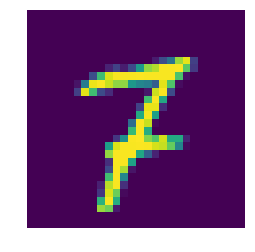

Label =  7
predicted Label =  7
Class probabilities =  [[  2.63259442e-10   5.45231433e-06   2.52802602e-06   5.81041058e-06
    2.87223467e-09   1.00891284e-09   1.33731595e-10   9.99985933e-01
    1.97025145e-07   2.13688853e-08]]
1/1 [==============================] - 0s 9ms/step


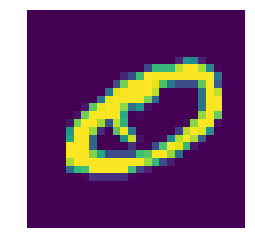

Label =  0
predicted Label =  0
Class probabilities =  [[  9.99998808e-01   2.70872994e-11   1.32567578e-07   1.08013221e-09
    1.48381585e-09   1.30564279e-08   3.72185525e-07   6.56545304e-11
    4.64929883e-07   2.33622302e-07]]
1/1 [==============================] - 0s 3ms/step


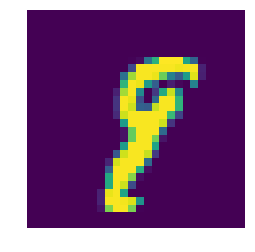

Label =  9
predicted Label =  9
Class probabilities =  [[  2.36120655e-07   2.11691513e-05   1.10751571e-07   1.17189067e-08
    2.84616181e-06   1.55246380e-05   6.62068729e-08   1.70036801e-05
    1.23775285e-02   9.87565458e-01]]
1/1 [==============================] - 0s 7ms/step


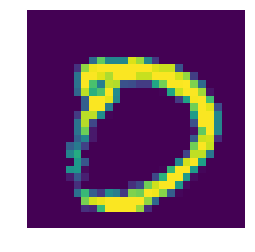

Label =  0
predicted Label =  0
Class probabilities =  [[  9.63135421e-01   3.21892579e-09   1.46699108e-07   1.20656450e-05
    5.29966826e-12   3.68300900e-02   1.44635649e-07   2.12713403e-05
    6.67854067e-07   1.47068363e-07]]
1/1 [==============================] - 0s 4ms/step


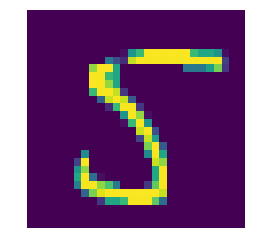

Label =  5
predicted Label =  5
Class probabilities =  [[  1.77590373e-11   5.51858455e-11   2.18745508e-11   3.05388692e-09
    3.89272490e-14   9.99562323e-01   1.26326538e-09   1.31010505e-13
    4.37635084e-04   1.37231684e-08]]


In [21]:
# plot 10 randomly selected digits from test dataset
plot_digits(model, X_test, y_test, input_shape)

In [22]:
# re-run the accuracy evaluation on the test model using the save best weights
get_best_model(filepath, X_test, y_test)

10000/10000 [==============================] - 16s 2ms/step
Best Test Loss: 0.023861
Best Test Accuracy: 0.992600
